In [37]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from sklearn.metrics import confusion_matrix
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']

In [33]:
_batch_size = 64
_learning_rate = 1e-4
max_epochs = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [18]:
img_change = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,),(0.5,)),
        transforms.RandomHorizontalFlip()
    ]
)

train_data = FashionMNIST(root='data', train=True, transform=img_change, download=True)
test_data = FashionMNIST(root='data', train=False, transform=img_change, download=True)

train_data_loader = DataLoader(train_data, batch_size=_batch_size, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=_batch_size, shuffle=False)

In [19]:
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()

        self.fc5 = nn.Linear(128 * 8 * 8, 512)
        self.drop1 = nn.Dropout2d()
        self.fc6 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = x.view(-1, 128 * 8 * 8)
        x = f.relu(self.fc5(x))
        x = self.drop1(x)
        x = self.fc6(x)
        
        return x

In [20]:
net = VGGNet().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=_learning_rate)

In [21]:
# 为绘图、保存和输出做些数据准备
train_epochs_loss = []
train_acc = []
test_epochs_loss = []
test_acc = []
best_acc = 0.0

# training and testing
print('Training and Testing ...\n')
for epoch in range(max_epochs):
    net.train()  # 进入训练模式，养成习惯
    train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
    for step, (tr_x, tr_y) in enumerate(train_data_loader):
        tr_x, tr_y = tr_x.to(device), tr_y.to(device)
        output = net(tr_x)  # 网络训练好的输出
        loss = loss_function(output, tr_y)  # 计算损失
        optimizer.zero_grad()  # 梯度先置0
        loss.backward()  # 根据损失函数后向传播，计算各参数的梯度
        optimizer.step()  # 参数更新

        train_l_sum += loss.item()  # 累计总损失
        train_acc_sum += (output.argmax(
            dim=1) == tr_y).sum().item()  # 累计预测正确的数目
        n += tr_y.shape[0]

    train_epochs_loss.append((train_l_sum / (step + 1)))
    train_acc.append(train_acc_sum / n)

    net.eval()  # 测试形态，不能忘
    acc_sum, num, te_loss = 0.0, 0, 0.0
    with torch.no_grad():  # 这一句也很重要，有时可以减少内存占用（具体原因未知）
        for bat_idx, (X, y) in enumerate(test_data_loader):
            te_out = net(X.to(device))
            acc_sum += (te_out.argmax(dim=1) == y.to(device)).sum().item()
            te_loss += loss_function(te_out, y.to(device)).item()
            num += y.shape[0]
    test_acc_epoch = acc_sum / num
    test_loss = te_loss / (bat_idx + 1)
    test_acc.append(test_acc_epoch)
    # 打印训练和测试，查看本次epoch结果
    print(
        'epoch: %d, loss %.4f, train_acc: %.3f,  test_acc: %.3f,  test_loss: %.3f, time %.1f sec'
        % (epoch + 1, train_l_sum / (step + 1), train_acc_sum / n,
           test_acc_epoch, test_loss, time.time() - start))
    test_epochs_loss.append(test_loss)

    if test_acc_epoch > best_acc:
        torch.save(net.state_dict(), 'cnn_params_best.pkl')
        best_acc = test_acc_epoch
        print('cnn has saved\n')


Training and Testing ...



d:\CodingSoftWare\Anaconda3\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1, loss 0.4245, train_acc: 0.849,  test_acc: 0.888,  test_loss: 0.306, time 93.9 sec
cnn has saved

epoch: 2, loss 0.2777, train_acc: 0.899,  test_acc: 0.900,  test_loss: 0.269, time 92.9 sec
cnn has saved

epoch: 3, loss 0.2371, train_acc: 0.913,  test_acc: 0.909,  test_loss: 0.251, time 95.5 sec
cnn has saved

epoch: 4, loss 0.2149, train_acc: 0.921,  test_acc: 0.912,  test_loss: 0.238, time 97.4 sec
cnn has saved

epoch: 5, loss 0.1953, train_acc: 0.929,  test_acc: 0.918,  test_loss: 0.230, time 96.6 sec
cnn has saved

epoch: 6, loss 0.1792, train_acc: 0.934,  test_acc: 0.919,  test_loss: 0.228, time 98.0 sec
cnn has saved

epoch: 7, loss 0.1654, train_acc: 0.939,  test_acc: 0.924,  test_loss: 0.213, time 99.6 sec
cnn has saved

epoch: 8, loss 0.1507, train_acc: 0.945,  test_acc: 0.924,  test_loss: 0.210, time 98.5 sec
cnn has saved

epoch: 9, loss 0.1387, train_acc: 0.948,  test_acc: 0.921,  test_loss: 0.222, time 98.7 sec
epoch: 10, loss 0.1292, train_acc: 0.953,  test_acc:

In [35]:
print("Best Test Accuracy: {}%".format(best_acc*100))

Best Test Accuracy: 93.15%


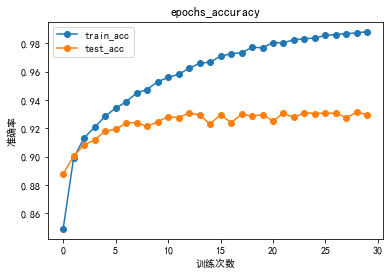

In [31]:
plt.plot(train_acc[:],'-o',label="train_acc")
plt.plot(test_acc[:],'-o',label="test_acc")
plt.title('epochs_accuracy')
plt.xlabel("训练次数")
plt.ylabel("准确率")
plt.legend()
plt.savefig('epochs_acc.png')


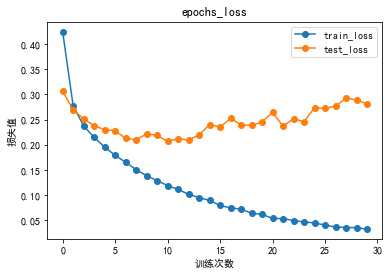

In [32]:
plt.plot(train_epochs_loss[:],'-o',label="train_loss")
plt.plot(test_epochs_loss[:],'-o',label="test_loss")
plt.title("epochs_loss")
plt.xlabel("训练次数")
plt.ylabel("损失值")
plt.legend()
plt.savefig('epochs_loss.png')

In [38]:
confusion_matrix(test_data)

TypeError: confusion_matrix() missing 1 required positional argument: 'y_pred'